# About Dataset
This dataset consists of reviews of fine foods from amazon. The data span a period of more than 10 years, including all ~500,000 reviews up to October 2012. Reviews include product and user information, ratings, and a plain text review. It also includes reviews from all other Amazon categories.

## Objectives

 - Perform exploratory data analysis (EDA).
 - Conduct data preprocessing and cleaning.
 - Evaluate transformer model performance.

In [3]:
%pip install polars
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf 
from tensorflow import keras    
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import compute_class_weight
from collections import Counter 
from tensorflow.keras.callbacks import EarlyStopping
import itertools
import warnings
warnings.filterwarnings(action="ignore")
from zipfile import ZipFile
sns.set_style("darkgrid")
sns.set_palette(palette=["gray", "red", "green"])
import random
import re

Note: you may need to restart the kernel to use updated packages.


In [4]:
tf.config.experimental.list_physical_devices('GPU')

[]

In [5]:
df = pl.read_csv("Reviews.csv")
df = df.select("Score", "Text")
df.head()

FileNotFoundError: No such file or directory (os error 2): Reviews.csv

In [ ]:
df.shape

(568454, 2)

# EDA & Preprocessing Data

 - Drop rows with null values.
 - Remove duplicate entries based on the "Text" column.
 - Remove tags, emails and URLs from the texts
 - Define a function 'get_sentiment' for sentiment categorization.

In [ ]:
df = df.drop_nulls()
df = df.unique(subset = "Text")

In [ ]:
def clean_text(text):
    text = re.sub(r'@[\w_]+', '', text)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'\S*@\S*\s?', '', text)

    return text.strip()

In [ ]:
df = df.with_columns(clean_text = pl.col(["Text"]).apply(clean_text))

In [ ]:
def get_sentiment(score): 
    if score > 3:
        return "Positive"
    elif score < 3:
        return "Negative"
    else:
        return "Neutral"

In [ ]:
df = df.with_columns(length = pl.col("clean_text").apply(lambda x: len(str(x).split())),
                    sentiment = pl.col("Score").apply(get_sentiment))

df.head()

Score,Text,clean_text,length,sentiment
i64,str,str,i64,str
2,"""I did not post…","""I did not post…",90,"""Negative"""
5,"""I fell in love…","""I fell in love…",104,"""Positive"""
5,"""Ronzoni's ziti…","""Ronzoni's ziti…",340,"""Positive"""
5,"""My small dog l…","""My small dog l…",100,"""Positive"""
1,"""We eat Cheerio…","""We eat Cheerio…",56,"""Negative"""


# Distribution of sentiment Categories.

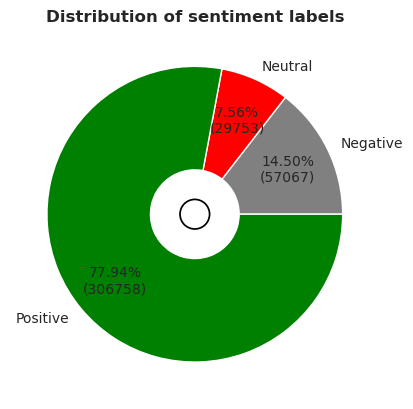

In [ ]:
sentiment_counts = df.groupby("sentiment").count()

ax, *_ = plt.pie(
    x=sentiment_counts["count"], 
    labels=sentiment_counts["sentiment"],
    autopct=lambda p: f'{p:.2f}%\n({int(p*sum(sentiment_counts["count"])/100)})', 
    wedgeprops=dict(width=0.7),
    textprops = dict(size=10),
    pctdistance = 0.7)

center_circle = plt.Circle((0, 0), 0.1, color='black', fc='white', linewidth=1.25)
fig = plt.gcf()
fig.gca().add_artist(center_circle)
plt.title("Distribution of sentiment labels", weight="bold")
plt.show()

### The dataset is highly imbalanced so I'll downsample the majority class.

In [ ]:
neu_df = df.filter(pl.col("sentiment") == "Neutral")
neg_df = df.filter(pl.col("sentiment") == "Negative")
pos_df = df.filter(pl.col("sentiment") == "Positive")
pos_df = pos_df.sample(len(neg_df))

df2 = pl.concat((neg_df, neu_df, pos_df), how="vertical")

In [ ]:
del neu_df, neg_df, pos_df, df  #To clear RAM due to the size of the dataset.

# Distribution of Sentences length.

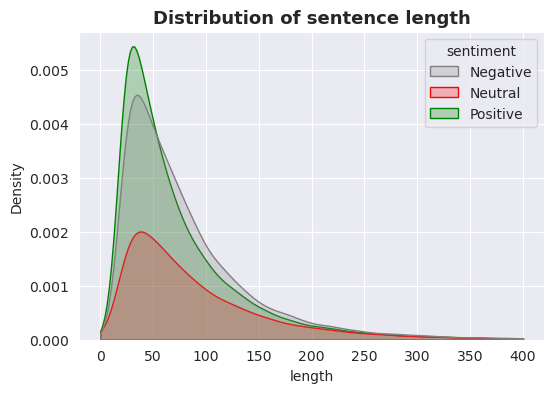

In [ ]:
fig = plt.figure(figsize=(6, 4))
sns.kdeplot(data=df2.to_pandas(), x="length", shade=True, hue="sentiment", clip=[0, 400])
plt.title("Distribution of sentence length", size=13, weight="bold")
plt.show()

In [ ]:
target = df2["sentiment"]
label_encoder = LabelEncoder()
target = label_encoder.fit_transform(target)

# Splitting the data to Training, Testing & Validation set

In [ ]:
def split_data(X, y = None, *, train_ratio=0.7, test_ratio=0.15, validation_ratio=0.15, seed=None):
    if train_ratio + test_ratio + validation_ratio != 1.0:
        raise ValueError("Ratios should add up to 1.0")

    total_length = len(X)
    train_size = int(train_ratio * total_length)
    test_size = int(test_ratio * total_length)

    if seed is not None:
        np.random.seed(seed)
    index = np.random.permutation(np.arange(total_length))
    X = X.take(index)

    train_X = X[:train_size]
    test_X = X[train_size:train_size + test_size]
    validation_X = X[train_size + test_size:]

    if y is not None:
        y = y[index]
        train_y = y[:train_size]
        test_y = y[train_size:train_size + test_size]
        validation_y = y[train_size + test_size:]

        return (train_X, train_y), (test_X, test_y), (validation_X, validation_y)
    return train_X, test_X, validation_X

In [ ]:
train_data, test_data, validation_data = split_data(
    df2["clean_text"],
    target,
    train_ratio=0.7,
    test_ratio=0.15,
    validation_ratio=0.15,
    seed=42)